# Data Exploration
## Sample Dataset
[sample dataset](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip)

In [1]:
# Libraries
import warnings
import zipfile
import mxnet as mx
warnings.simplefilter('ignore')

# Download and extract Sample Data
file = mx.test_utils.download(url='https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip')
with zipfile.ZipFile(file) as zf:
    zf.extractall()

## View the Data

In [2]:
# Libraries
import pandas as pd

# View the data
data_df = pd.read_csv('./data/driving_log.csv')
data_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


## Describe the Data

In [3]:
# Data Overview
print("Dataset Shape: {}\n".format(data_df.shape))
print(data_df.describe())

Dataset Shape: (8036, 7)

          steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360


## Visualize the Data

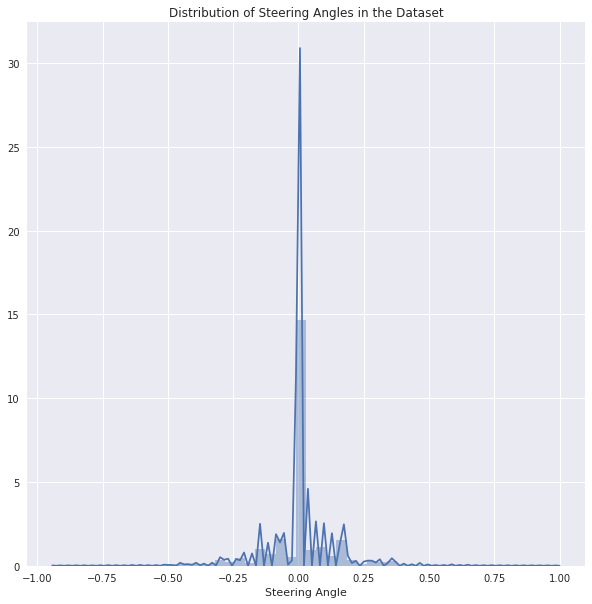

In [4]:
# Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize the distribution of the data
sns.set(rc={'figure.figsize':(10, 10)})
fig = sns.distplot(data_df.steering)
plt.xlabel("Steering Angle")
plt.title("Distribution of Steering Angles in the Dataset")
plt.show(fig);

The Sample Dataset is skewed toward the zero steering angle and therefore more training data will need to be added during the Data Preprocessing step.

---
# Data Preprocesing
## Feature Extraction

In [5]:
# Separate the features
X = data_df[['center', 'left', 'right']].values
y = data_df['steering'].values

## Image Transformations
1. Crop images for Region of Interest (ROI).
2. Resize images to $66 \times 200 \times 3$ per the NVidia model.
3. Convert to YUV Channels per the NVidia model.

In [6]:
# Libraries
import cv2

# Image Transofmrations
def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :, :] # remove the sky and the car front

In [7]:
def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)

In [8]:
def rgb2yuv(image):
    """
    Convert the image from RGB to YUV
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

## Image Augmentation
- Randomly choose right, left or center images.
- For left image, steering angle is adjusted by +0.2
- For right image, steering angle is adjusted by -0.2
- Randomly flip image left <--> right
- Randomly translate image horizontally with steering angle adjustment (0.002 per pixel shift)
- Randomly translate image virtically
- Randomly added shadows
- Randomly altering image brightness (lighter or darker)
- Randonly apply distortions

In [9]:
# Libraries
import numpy as np

# Randomly Flip image Left/Right
def random_flip(image, steering_angle):
    """
    Randomly flit the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

__blah blah blah__

In [10]:
# Randomly Translate Vertically and Horizontally
def translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

__blah blah blah__

In [11]:
def distort(image):
    ''' 
    method for adding random distortion to dataset images, including random brightness adjust, and a random
    vertical shift of the horizon position
    '''
    new_img = image.astype(float)
    # random brightness - the mask bit keeps values from going beyond (0,255)
    value = np.random.randint(-28, 28)
    if value > 0:
        mask = (new_img[:,:,0] + value) > 255 
    if value <= 0:
        mask = (new_img[:,:,0] + value) < 0
    new_img[:,:,0] += np.where(mask, 0, value)
    # random shadow - full height, random left/right side, random darkening
    h,w = new_img.shape[0:2]
    mid = np.random.randint(0,w)
    factor = np.random.uniform(0.6,0.8)
    if np.random.rand() > .5:
        new_img[:,0:mid,0] *= factor
    else:
        new_img[:,mid:w,0] *= factor
    # randomly shift horizon
    h,w,_ = new_img.shape
    horizon = 2*h/5
    v_shift = np.random.randint(-h/8,h/8)
    pts1 = np.float32([[0,horizon],[w,horizon],[0,h],[w,h]])
    pts2 = np.float32([[0,horizon+v_shift],[w,horizon+v_shift],[0,h],[w,h]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    new_img = cv2.warpPerspective(new_img,M,(w,h), borderMode=cv2.BORDER_REPLICATE)
    return new_img.astype(np.uint8)

__blah blah blah__

In [12]:
# Radomly Adjust Brightness
def brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

## Augmented Image Examples

### Random Sample Image

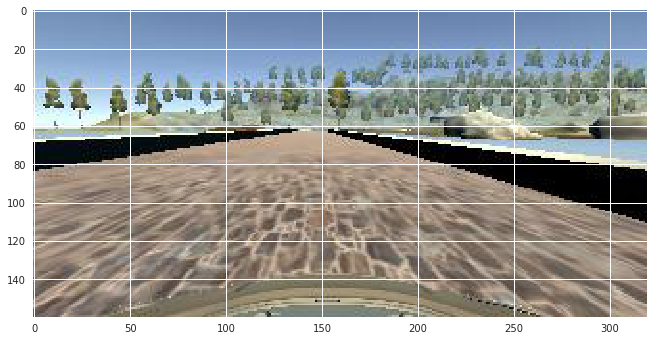

In [13]:
# Libraries
import os
import matplotlib.image as mpimg

# Helper functions
def load(data_dir, image_file):
    """
    Load RGB images from a file
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

def transform(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image

# Origional 'left' image
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
random_image = X[100][0]
img = load('data', random_image)
plt.rcParams['figure.figsize'] = (11.0, 10.0)
plt.imshow(img);

### Augmented Images

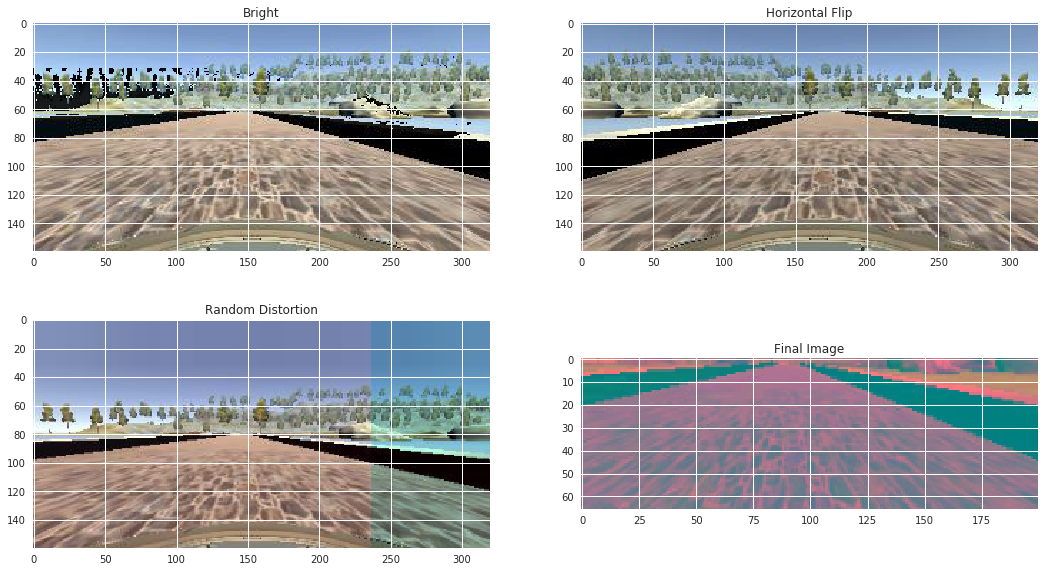

In [14]:
# Create Subpluts for Augmented Images
plt.close('all')
fig = plt.figure(figsize=(18., 10.))
sub1 = fig.add_subplot(221)
sub1.set_title('Bright')
sub1.imshow(brightness(img))
sub2 = fig.add_subplot(222)
sub2.set_title('Horizontal Flip')
sub2.imshow(cv2.flip(img, 1))
sub3 = fig.add_subplot(223)
sub3.set_title('Random Distortion')
sub3.imshow(distort(img));
sub4 = fig.add_subplot(224)
sub4.set_title('Final Image')
sub4.imshow(transform(img));
plt.show()

## Image Augmentation Pipeline...
__BLah Blah Blah__

In [17]:
# Batch Image Configurations
HEIGHT, WIDTH, CHANNELS = 66, 200, 3
INPUT_SHAPE = (HEIGHT, WIDTH, CHANNELS)

# Aumentation Pipeline Functions
def choose(data_dir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load(data_dir, right), steering_angle - 0.2
    return load(data_dir, center), steering_angle

def augument(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose(data_dir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = translate(image, steering_angle, range_x, range_y)
    image = brightness(image)
    image = distort(image)
    return image, steering_angle

def aug_pipeline(data_dir, image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, HEIGHT, WIDTH, CHANNELS])
    steering = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 0.9:
                image, steering_angle = augument(data_dir, center, left, right, steering_angle)
            else:
                image = load(data_dir, center) 
            # add the image and steering angle to the batch
            images[i] = transform(image)
            steering[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        return np.array(images).astype(np.float32), np.array(steering).astype(np.float32)

Use the Augmentation Piopeline functions to create the Training and Vlaidation Datasets using a 90/10 split respectivley. There is no Test Dataset as the final test will be acomplished using the Simulator.

In [18]:
X_sample, y_sample = aug_pipeline('data', X, y, len(X), True)

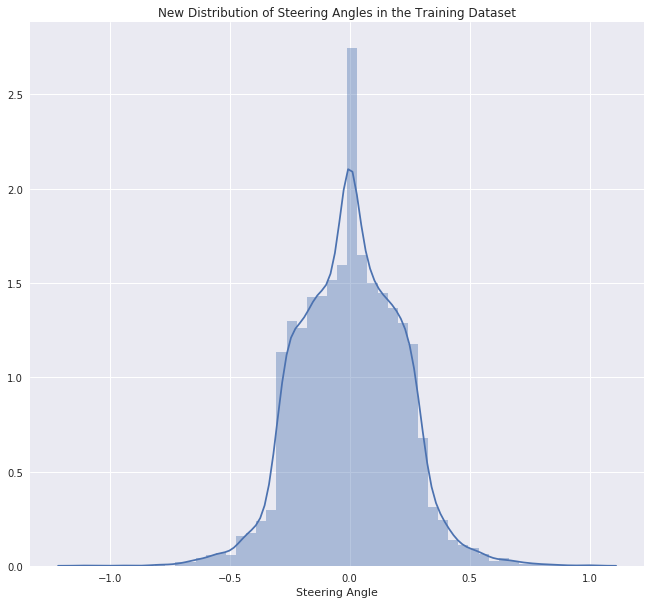

In [19]:
# Plot New Distribution of training examples
fig = sns.distplot(y_sample)
plt.xlabel("Steering Angle")
plt.title("New Distribution of Steering Angles in the Training Dataset")
plt.show(fig);

As can be seen from the sample datatset, the disribution of steering angles is more uniform. Next we create the datasets for the model and upload them to S3.

---
# Prepare the Training/Validation Datsets
Using a 90/10 split, the dataset is separated to 90% for Training and 10% for Validation. The final test onm the datset will be handled by the simulator.

In [ ]:
# Libraries and session configuration
import sagemaker
from sklearn.model_selection import train_test_split
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# Create Training and Validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# Preprocess through the pipline
X_train, y_train = aug_pipeline('data', X_train, y_train, len(X_train), True)
X_valid, y_valid = aug_pipeline('data', X_valid, y_valid, len(X_valid), False)

# Reshape images as a 4D Tensor
X_train = X_train.reshape(-1, 3, 66, 200)
y_train = y_train.reshape(-1, 1)
X_valid = X_valid.reshape(-1, 3, 66, 200)
y_valid = y_valid.reshape(-1, 1)

# Create local repository for Numpy Arrays
if not os.path.exists('/tmp/data'):
    os.mkdir('/tmp/data')

# Save the Dataset as Numpy Arrays
np.save('/tmp/data/train_X.npy', X_train)
np.save('/tmp/data/train_Y.npy', y_train)
np.save('/tmp/data/valid_X.npy', X_valid)
np.save('/tmp/data/valid_Y.npy', y_valid)

# Upload the Training and Testing Data to S3
input_data = sagemaker_session.upload_data(path='/tmp/data', key_prefix='training_input')
bucket = input_data.split('/')[2]

---
# Next Steps: Build and Train the model
[Module 2: SageMaker Image Classification](../2_SageMakerImageClassification/README.md)